In [178]:
import pandas as pd 
import selenium 
from selenium import webdriver 
from bs4 import BeautifulSoup 
import time 
from tqdm import tnrange 
from urllib.request import urlopen 
import re 
import requests 
import urllib.request 
from tqdm import tqdm

In [179]:
!pip install selenium
!apt-get update
!apt install chromium-chromedriver -y

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
chromium-chromedriver is already the newest version (99.0.4844.84-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 67 not upgraded.


In [180]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By

In [181]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') #내부 창을 띄울 수 없으므로 설정
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [182]:
driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)

<ipython-input-182-f4745e3da145>:1: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome('chromedriver',chrome_options=chrome_options)


# 함수 정의
* kor_to_trans 함수 : 한국어를 외국어로 바꾸는 함수
* trans_to_kor 함수 : 외국어를 한국어로 바꾸는 함수 
* under_data: num개 이하의 label에 해당하는 데이터만 추출하는 함수
* back_translate : 번역하기 & backtrans_list에 데이터 축적하는 함수 (한국어->외국어->한국어)
* create_augmented_df : 생성된 데이터에서 entity index를 찾아 정제된 augmented dataframe을 생성하는 함수

In [183]:
# kor_to_trans 함수 -> 한국어를 외국어로 바꾸는 함수 
# trans_to_kor 함수 -> 외국어를 한국어로 바꾸는 함수 

def kor_to_trans(text_data, trans_lang): 
    """ trans_lang에 넣는 파라미터 값: 'en' -> 영어 'ja&hn=0' -> 일본어 'zh-CN' -> 중국어(간체) """ 
    trans_list = []
    for i in tqdm(range(len(text_data))): 
        try: 
            driver.get('https://papago.naver.com/?sk=ko&tk='+trans_lang+'&st='+text_data[i]) 
            time.sleep(2.5) 
            backtrans = driver.find_element_by_xpath('//*[@id="txtTarget"]').text 
            trans_list.append(backtrans) 
        except: 
            driver.get('https://papago.naver.com/?sk=ko&tk='+trans_lang) 
            driver.find_element_by_xpath('//*[@id="txtSource"]').send_keys(text_data[i]) 
            time.sleep(2.5) 
            backtrans = driver.find_element_by_xpath('//*[@id="txtTarget"]').text 
            trans_list.append(backtrans)
    return trans_list
            
def trans_to_kor(transed_list, transed_lang): 
    for i in tqdm(range(len(transed_list))): 
        try: 
            driver.get('https://papago.naver.com/?sk='+transed_lang+'&tk=ko&st='+transed_list[i]) 
            time.sleep(2.5) 
            backtrans = driver.find_element_by_xpath('//*[@id="txtTarget"]').text 
            backtrans_list.append(backtrans) 
        except: 
            driver.get('https://papago.naver.com/?sk='+transed_lang+'&tk=ko') 
            driver.find_element_by_xpath('//*[@id="txtSource"]').send_keys(transed_list[i]) 
            time.sleep(2.5) 
            backtrans = driver.find_element_by_xpath('//*[@id="txtTarget"]').text 
            backtrans_list.append(backtrans)


In [161]:
for i in df['sentence']:
    print(i)
    break

1924년 11월 26일에는 정부 형태를 군주제에서 인민 공화제로 고쳐 국호를 몽골 인민 공화국으로 정하고, 세계에서 2번째로 공산주의 국가가 되었다.


In [184]:
def under_data(num):
    under_data = pd.DataFrame()
    for k,v in relation_data['label'].value_counts().items():
        if v < num:
            under_key = data[data['label'] == k]
            under_data = pd.concat([under_data, under_key])

    return under_data

In [185]:
# 번역하기 & backtrans_list에 데이터 축적
def back_translate(trans_list, language):
    # 한국어 -> 외국어 -> 한국어
    # trans_list = kor_to_trans(df['sentence'], language)
    trans_to_kor(trans_list, language)

In [186]:
# entity index 찾아서 생성된 데이터들을 저장한 df 생성
def create_augmented_df(df, backtrans_df):
    temp_backtrans_df = pd.DataFrame()
    # unmatch = 0
    for i in range(len(u100_data)*2):
        se_dict = {}
        oe_dict = {}
        
        # subject entity, object entity 
        se = eval(u100_data.loc[i%len(u100_data)]['subject_entity'])['word']
        oe = eval(u100_data.loc[i%len(u100_data)]['object_entity'])['word']
        
        # back_translation에서의 인덱스 위치 구하기
        ## subject entity
        se_start_idx = backtrans_list[i].find(se)
        if se_start_idx == -1:
            # print("subject entity에 해당하는 단어가 없습니다.")
            # unmatch += 1
            continue

        se_end_idx = se_start_idx + len(se)
        if se != backtrans_list[i][se_start_idx:se_end_idx]:
            print("오류: 인덱스가 잘못 설정됨.")
            break
        else:
            se_dict['word'] = se
            se_dict['start_idx'] = se_start_idx
            se_dict['end_idx'] = se_end_idx
            se_dict['type'] = eval(df.loc[i%len(u100_data)]['subject_entity'])['type']
        ## object entity
        oe_start_idx = backtrans_list[i].find(oe)
        if oe_start_idx == -1:
            # print("object entity에 해당하는 단어가 없습니다.")
            # unmatch += 1
            continue

        oe_end_idx = oe_start_idx + len(oe)
        if oe != backtrans_list[i][oe_start_idx:oe_end_idx]:
            print("오류: 인덱스가 잘못 설정됨.")
            # print(se, backtrans_list[i][se_start_idx:se_end_idx])
            break
        else:
            oe_dict['word'] = oe
            oe_dict['start_idx'] = oe_start_idx
            oe_dict['end_idx'] = oe_end_idx
            oe_dict['type'] = eval(df.loc[i%len(u100_data)]['object_entity'])['type']

        temp_backtrans_df = temp_backtrans_df.append(pd.DataFrame([[int(u100_data[['id']].loc[i%len(u100_data)]), backtrans_list[i], str(se_dict), str(oe_dict), u100_data[['label']].loc[i%len(u100_data)][0],u100_data[['source']].loc[i%len(u100_data)][0]]], columns=list(u100_data.columns)))
    # backtrans_df에 temp_backtrans_df 추가하기
    backtrans_df = pd.concat([backtrans_df, temp_backtrans_df])
    backtrans_df.reset_index(drop = True, inplace = True)
    backtrans_df

--------

In [188]:
data = pd.read_csv('../dataset/train/train.csv')
data.sample(5)

,id,sentence,subject_entity,object_entity,label,source
601,601,"김우빈은 최영도의 말투를 직접 만들었다고 밝혔는데, 11월 21일 《친구 2》미디어...","{'word': '최영도', 'start_idx': 5, 'end_idx': 7, ...","{'word': '김우빈', 'start_idx': 0, 'end_idx': 2, ...",per:alternate_names,wikipedia
31150,31150,그리고 공주시·부여군·청양군 역시 더불어민주당 박수현 후보(44.95%)와 국민의당...,"{'word': '박수현', 'start_idx': 26, 'end_idx': 28...","{'word': '더불어민주당', 'start_idx': 19, 'end_idx':...",per:employee_of,wikipedia
5761,5761,"1949년~1950년에는 교환 학생으로 파리 대학교에 머물렀으며, 여기서 장 르레 ...","{'word': '로제 고드망', 'start_idx': 67, 'end_idx':...","{'word': '앙리 카르탕', 'start_idx': 48, 'end_idx':...",per:colleagues,wikipedia
18351,18351,"이어서 멤버별로 슈가(민윤기·26), RM(김남준·25), 제이홉(정호석·25), ...","{'word': '제이홉', 'start_idx': 33, 'end_idx': 35...","{'word': '정호석', 'start_idx': 37, 'end_idx': 39...",per:alternate_names,wikitree
13334,13334,"5월에는 《유희열의 스케치북》 100회 특집으로 이뤄진 ""레이블 특집""에서 Buda...","{'word': '45RPM', 'start_idx': 70, 'end_idx': ...","{'word': 'Buda Sound', 'start_idx': 42, 'end_i...",no_relation,wikipedia


In [189]:
data['label'].value_counts()

no_relation                            9534
org:top_members/employees              4284
per:employee_of                        3573
per:title                              2103
org:member_of                          1866
org:alternate_names                    1320
per:origin                             1234
org:place_of_headquarters              1195
per:date_of_birth                      1130
per:alternate_names                    1001
per:spouse                              795
per:colleagues                          534
per:parents                             520
org:founded                             450
org:members                             420
per:date_of_death                       418
org:product                             380
per:children                            304
per:place_of_residence                  193
per:other_family                        190
per:place_of_birth                      166
org:founded_by                          155
per:product                     

<AxesSubplot:>

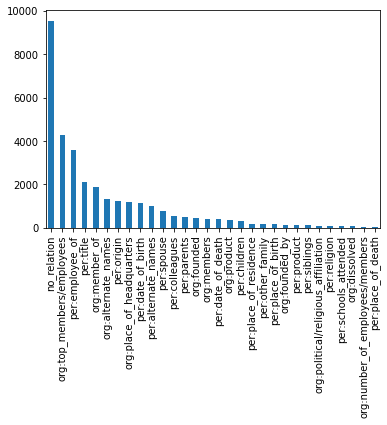

In [195]:
data['label'].value_counts().plot(kind='bar')

In [12]:
relation_data = data[data['label'] != "no_relation"]

In [13]:
# label 개수 100개 미만의 데이터셋
u100_data = under_data(100)
u100_data.reset_index(drop = True, inplace = True)
u100_data

,id,sentence,subject_entity,object_entity,label,source
0,50,1924년 11월 26일에는 정부 형태를 군주제에서 인민 공화제로 고쳐 국호를 몽골...,"{'word': '몽골 인민 공화국', 'start_idx': 44, 'end_id...","{'word': '공화제', 'start_idx': 32, 'end_idx': 34...",org:political/religious_affiliation,wikipedia
1,280,교황령의 통치자인 교황은 가톨릭교회의 종교 지도자이기도 하였다.,"{'word': '교황령', 'start_idx': 0, 'end_idx': 2, ...","{'word': '가톨릭', 'start_idx': 14, 'end_idx': 16...",org:political/religious_affiliation,wikipedia
2,355,"캄푸치아 인민공화국, 에티오피아 인민 민주주의공화국, 남예멘이 공산주의를 버렸고, ...","{'word': '몽골 인민 공화국', 'start_idx': 46, 'end_id...","{'word': '공산주의', 'start_idx': 35, 'end_idx': 3...",org:political/religious_affiliation,wikipedia
3,442,"폴란드에서 교복이라는 개념은 20세기 초반까지는 존재하지 않았지만, 폴란드에 공산주...","{'word': '폴란드 인민 공화국', 'start_idx': 52, 'end_i...","{'word': '공산주의', 'start_idx': 43, 'end_idx': 4...",org:political/religious_affiliation,wikipedia
4,516,"레베데프는 과거 소비에트 연방의 대통령이었던 고르바초프와도 함께 일하고 있으며, 자...","{'word': '노바야 가제타', 'start_idx': 58, 'end_idx'...","{'word': '자유주의', 'start_idx': 45, 'end_idx': 4...",org:political/religious_affiliation,wikipedia
...,...,...,...,...,...,...
425,27079,1612년 9월 12일 고스티닌 성에서 사망했으며 1635년 러시아 차르국의 차르였...,"{'word': '바실리 4세', 'start_idx': 63, 'end_idx':...","{'word': '고스티닌 성', 'start_idx': 13, 'end_idx':...",per:place_of_death,wikipedia
426,28332,내부 마케도니아 혁명 기구의 회원으로 활동했으며 1934년에는 프랑스 마르세유에서 ...,"{'word': '알렉산다르 1세', 'start_idx': 57, 'end_idx...","{'word': '프랑스 마르세유', 'start_idx': 35, 'end_idx...",per:place_of_death,wikipedia
427,29266,묵돌이 선우가 된 209년에는 진시황이 사망한 직후였으며 이로 인해 진나라가 큰 혼...,"{'word': '진시황', 'start_idx': 17, 'end_idx': 19...","{'word': '진나라', 'start_idx': 38, 'end_idx': 40...",per:place_of_death,wikipedia
428,30008,"만네르헤임은 1951년 1월 27일(협정 세계시), 핀란드 시간으로는 1월 28일 ...","{'word': '만네르헤임', 'start_idx': 0, 'end_idx': 4...","{'word': '스위스 로잔', 'start_idx': 46, 'end_idx':...",per:place_of_death,wikipedia


In [146]:
# label 개수 100개 미만의 데이터셋
u1000_data = under_data(1000)
u1000_data.reset_index(drop = True, inplace = True)
u1000_data

,id,sentence,subject_entity,object_entity,label,source
0,22,"박흥식은 첫 부인과의 사이에 장녀 박병숙을 두었고, 두 번째 부인은 경희대학교 교수...","{'word': '박흥식', 'start_idx': 0, 'end_idx': 2, ...","{'word': '한인하', 'start_idx': 57, 'end_idx': 59...",per:spouse,wikipedia
1,25,"SK는 또 ""해당 방송에서 언급한 지난해 12월5일 가로세로연구소 유튜브 방송 또한...","{'word': '노소영', 'start_idx': 110, 'end_idx': 1...","{'word': '최태원', 'start_idx': 67, 'end_idx': 69...",per:spouse,wikitree
2,33,채리나는 이후 박용근을 생명의 은인으로 여기고 교제하다가 2016년 11월에 결혼하였다.,"{'word': '채리나', 'start_idx': 0, 'end_idx': 2, ...","{'word': '박용근', 'start_idx': 8, 'end_idx': 10,...",per:spouse,wikipedia
3,40,배우 장신영(35) 씨와 남편 강경준(36) 씨가 둘째를 품에 안았다.,"{'word': '강경준', 'start_idx': 17, 'end_idx': 19...","{'word': '장신영', 'start_idx': 3, 'end_idx': 5, ...",per:spouse,wikitree
4,77,문재인 대통령 부인 김정숙 여사가 22일 오후 광주 광산구 남부대 시립국제수영장에서...,"{'word': '문재인', 'start_idx': 0, 'end_idx': 2, ...","{'word': '김정숙', 'start_idx': 11, 'end_idx': 13...",per:spouse,wikitree
...,...,...,...,...,...,...
5225,27079,1612년 9월 12일 고스티닌 성에서 사망했으며 1635년 러시아 차르국의 차르였...,"{'word': '바실리 4세', 'start_idx': 63, 'end_idx':...","{'word': '고스티닌 성', 'start_idx': 13, 'end_idx':...",per:place_of_death,wikipedia
5226,28332,내부 마케도니아 혁명 기구의 회원으로 활동했으며 1934년에는 프랑스 마르세유에서 ...,"{'word': '알렉산다르 1세', 'start_idx': 57, 'end_idx...","{'word': '프랑스 마르세유', 'start_idx': 35, 'end_idx...",per:place_of_death,wikipedia
5227,29266,묵돌이 선우가 된 209년에는 진시황이 사망한 직후였으며 이로 인해 진나라가 큰 혼...,"{'word': '진시황', 'start_idx': 17, 'end_idx': 19...","{'word': '진나라', 'start_idx': 38, 'end_idx': 40...",per:place_of_death,wikipedia
5228,30008,"만네르헤임은 1951년 1월 27일(협정 세계시), 핀란드 시간으로는 1월 28일 ...","{'word': '만네르헤임', 'start_idx': 0, 'end_idx': 4...","{'word': '스위스 로잔', 'start_idx': 46, 'end_idx':...",per:place_of_death,wikipedia


In [147]:
# 재번역된 모든 senteces 저장할 list 
backtrans_list = []
# 생성 & 정제된 모든 데이터를 저장할 최종 augmented dataframe
backtrans_df = pd.DataFrame()

In [149]:
u1000_data['sentence'][0]

'박흥식은 첫 부인과의 사이에 장녀 박병숙을 두었고, 두 번째 부인은 경희대학교 교수를 지낸 피아니스트 한인하이며, 두 사람 사이에서 태어난 딸 박봉숙은 이화여자대학교 교수를 지냈다.'

In [155]:
u1000_data['sentence']

0       박흥식은 첫 부인과의 사이에 장녀 박병숙을 두었고, 두 번째 부인은 경희대학교 교수...
1       SK는 또 "해당 방송에서 언급한 지난해 12월5일 가로세로연구소 유튜브 방송 또한...
2       채리나는 이후 박용근을 생명의 은인으로 여기고 교제하다가 2016년 11월에 결혼하였다.
3                 배우 장신영(35) 씨와 남편 강경준(36) 씨가 둘째를 품에 안았다.
4       문재인 대통령 부인 김정숙 여사가 22일 오후 광주 광산구 남부대 시립국제수영장에서...
                              ...                        
5225    1612년 9월 12일 고스티닌 성에서 사망했으며 1635년 러시아 차르국의 차르였...
5226    내부 마케도니아 혁명 기구의 회원으로 활동했으며 1934년에는 프랑스 마르세유에서 ...
5227    묵돌이 선우가 된 209년에는 진시황이 사망한 직후였으며 이로 인해 진나라가 큰 혼...
5228    만네르헤임은 1951년 1월 27일(협정 세계시), 핀란드 시간으로는 1월 28일 ...
5229    1593년 6월 2차 진주성 전투에서 진주성이 함락되자 의병장인 김천일·고종후와 함...
Name: sentence, Length: 5230, dtype: object

In [ ]:
# 한국어 -> 외국어
trans_list_en = kor_to_trans(u1000_data['sentence'], 'en')
trans_list_jp = kor_to_trans(u1000_data['sentence'], 'ja&hn=0')
trans_list_cn = kor_to_trans(u1000_data['sentence'], 'zh-CN')

In [ ]:
# 외국어 -> 한국어
back_translate(trans_list_en, 'en') # 영어
back_translate(trans_list_jp, 'ja&hn=0') # 일본어
back_translate(trans_list_cn, 'zh-CN') # 중국어

In [ ]:
def print_translation(language, trans_list, n):
    print(f"한국어 -> {language} -> 한국어")
    for i in range(n):
        print('원본: \n%s \n번역 후: \n%s \n결과: \n%s' %(u100_data['sentence'][i], trans_list_jp[i], backtrans_list[i]))
        print('-'*100)

In [ ]:
print_translation('영어', trans_list_en, 1)
print_translation('일본어', trans_list_jp, 1)
print_translation('중국어', trans_list_cn, 1)

In [46]:
print("한국어 -> 일본어 -> 한국어")
for i in range(5):
    print('원본: \n%s \n번역 후: \n%s \n결과: \n%s' %(u100_data['sentence'][i], trans_list_jp[i], backtrans_list[i]))
    print('-'*100)

한국어 -> 일본어 -> 한국어
원본: 
1924년 11월 26일에는 정부 형태를 군주제에서 인민 공화제로 고쳐 국호를 몽골 인민 공화국으로 정하고, 세계에서 2번째로 공산주의 국가가 되었다. 
결과: 
1924년 11월 26일에는 정부 형태를 군주제에서 인민공화제로 바꾸고, 국호를 몽골인민공화국으로 정하면서 세계에서 두 번째로 공산주의 국가가 되었다.
----------------------------------------------------------------------------------------------------
원본: 
교황령의 통치자인 교황은 가톨릭교회의 종교 지도자이기도 하였다. 
결과: 
교황령의 통치자인 교황은 가톨릭 교회의 종교 지도자이기도 했다.
----------------------------------------------------------------------------------------------------
원본: 
캄푸치아 인민공화국, 에티오피아 인민 민주주의공화국, 남예멘이 공산주의를 버렸고, 몽골 인민 공화국에서는 혁명이 발생해 공산주의의 일당 체제가 붕괴되었다. 
결과: 
캄푸치아인민공화국, 에티오피아인민민주주의공화국, 남예멘이 공산주의를 버리고 몽골인민공화국에서는 혁명이 발생하여 공산주의 일당체제가 붕괴되었다.
----------------------------------------------------------------------------------------------------
원본: 
폴란드에서 교복이라는 개념은 20세기 초반까지는 존재하지 않았지만, 폴란드에 공산주의 정권인 폴란드 인민 공화국이 수립되고 나서 교복을 착용했다가 1980년대 경제적인 악화로 인해 많은 학교에서 교복을 취소하고 말았다. 
결과: 
폴란드에서는 교복이 20세기 초까지 존재하지 않았으나 폴란드에 공산주의 정권인 폴란드 인민공화국이 수립되면서 교복을 착용했으나 1980년대 경제적 악화로 많은 학교에서 교복을 취소했다.

In [47]:
print("한국어 -> 중국어 -> 한국어")
for i in range(5):
    print('원본: \n%s \n번역 후: \n%s \n결과: \n%s' %(u100_data['sentence'][i], trans_list_cn[i], backtrans_list[i+430]))
    print('-'*100)

한국어 -> 중국어 -> 한국어
원본: 
1924년 11월 26일에는 정부 형태를 군주제에서 인민 공화제로 고쳐 국호를 몽골 인민 공화국으로 정하고, 세계에서 2번째로 공산주의 국가가 되었다. 
결과: 
1924년 11월 26일 정부 형태를 군주제에서 인민공화국으로 바꾸고 국호를 몽골인민공화국으로 정하면서 세계에서 두 번째 공산주의 국가가 됐다.
----------------------------------------------------------------------------------------------------
원본: 
교황령의 통치자인 교황은 가톨릭교회의 종교 지도자이기도 하였다. 
결과: 
교황령의 통치자인 교황은 가톨릭교회의 종교 지도자이기도 하다.
----------------------------------------------------------------------------------------------------
원본: 
캄푸치아 인민공화국, 에티오피아 인민 민주주의공화국, 남예멘이 공산주의를 버렸고, 몽골 인민 공화국에서는 혁명이 발생해 공산주의의 일당 체제가 붕괴되었다. 
결과: 
캄푸치아 인민공화국, 에티오피아 인민민주주의공화국, 남예멘이 공산주의를 버렸고 몽골 인민공화국에서 혁명이 일어나 공산주의의 일당체제가 붕괴됐다.
----------------------------------------------------------------------------------------------------
원본: 
폴란드에서 교복이라는 개념은 20세기 초반까지는 존재하지 않았지만, 폴란드에 공산주의 정권인 폴란드 인민 공화국이 수립되고 나서 교복을 착용했다가 1980년대 경제적인 악화로 인해 많은 학교에서 교복을 취소하고 말았다. 
결과: 
폴란드에는 20세기 초반까지만 해도 교복 개념이 없었으나 폴란드에 공산주의 정권이 세워진 이후 교복을 입고 다니다가 1980년대 경제 악화로 교복을 없애는 학교가 많았다.
-----------

In [33]:
# 최종 augmented_dataframe 생성 (start_idx, end_idx)
create_augmented_df(u100_data, backtrans_df)

In [88]:
len(backtrans_list)

860

In [59]:
# print("불일치 데이터 개수:", unmatch)

불일치 데이터 개수: 321


In [ ]:
# 최종 증강 데이터
aug_data = pd.concat([data, backtrans_df])
aug_data.reset_index(drop = True, inplace = True)
aug_data

In [ ]:
# aug_data.loc[33234]['object_entity'] # entity 제대로 생겼나 확인

"{'word': '진주성', 'start_idx': 13, 'end_idx': 16, 'type': 'POH'}"

<AxesSubplot:>

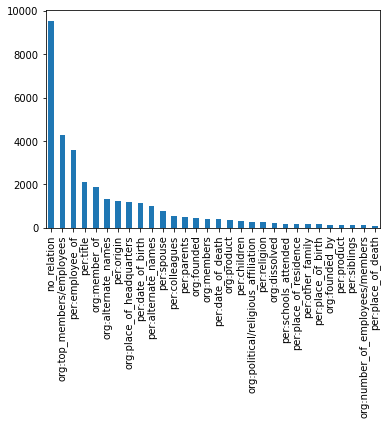

In [125]:
aug_data['label'].value_counts().plot(kind='bar')

In [130]:
# 저장
aug_data.to_csv("./just_aug_data.csv")

---
+) no relation 버리기

In [191]:
# no_relation 데이터 반으로 잘라버리기
aug_relation_data = aug_data[aug_data['label'] == "no_relation"]
sub_relation_data = aug_relation_data[:aug_relation_data.shape[0]//2]
set_diff_df = pd.concat([aug_data, sub_relation_data]).drop_duplicates(keep=False)
set_diff_df

,Unnamed: 0,id,sentence,subject_entity,object_entity,label,source
2,2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
5,5,5,": 유엔, 유럽 의회, 북대서양 조약 기구 (NATO), 국제이주기구, 세계 보건 ...","{'word': '북대서양 조약 기구', 'start_idx': 13, 'end_i...","{'word': 'NATO', 'start_idx': 25, 'end_idx': 2...",org:alternate_names,wikipedia
7,7,7,"박용오(朴容旿, 1937년 4월 29일(음력 3월 19일)(음력 3월 19일) ~ ...","{'word': '박용오', 'start_idx': 0, 'end_idx': 2, ...","{'word': '1937년 4월 29일', 'start_idx': 9, 'end_...",per:date_of_birth,wikipedia
8,8,8,중공군에게 온전히 대항할 수 없을 정도로 약해진 국민당은 타이베이로 수도를 옮기는 ...,"{'word': '중화민국', 'start_idx': 59, 'end_idx': 6...","{'word': '타이베이', 'start_idx': 32, 'end_idx': 3...",org:place_of_headquarters,wikipedia
...,...,...,...,...,...,...,...
32691,32691,24642,"1947년 7월 서울에서 여운형이 피살된 후, 그는 노동당을 이끌고 1948년 4월...","{'word': '여운형', 'start_idx': 14, 'end_idx': 17...","{'word': '서울', 'start_idx': 9, 'end_idx': 11, ...",per:place_of_death,wikipedia
32692,32692,26540,기원전 42년 10월 마케도니아의 필리피에서 벌어진 두 번의 전투 끝에 로마군이 승...,"{'word': '브루투스', 'start_idx': 50, 'end_idx': 5...","{'word': '필리피', 'start_idx': 19, 'end_idx': 22...",per:place_of_death,wikipedia
32693,32693,27079,"1612년 9월 12일, 그는 고스티닌 성에서 사망했고 1635년 바실리 4세의 시...","{'word': '바실리 4세', 'start_idx': 37, 'end_idx':...","{'word': '고스티닌 성', 'start_idx': 17, 'end_idx':...",per:place_of_death,wikipedia
32694,32694,30008,만네르헤임은 1951년 1월 27일 스위스 로잔의 주립병원에서 사망했다.,"{'word': '만네르헤임', 'start_idx': 0, 'end_idx': 5...","{'word': '스위스 로잔', 'start_idx': 20, 'end_idx':...",per:place_of_death,wikipedia


In [192]:
set_diff_df

,Unnamed: 0,id,sentence,subject_entity,object_entity,label,source
2,2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
5,5,5,": 유엔, 유럽 의회, 북대서양 조약 기구 (NATO), 국제이주기구, 세계 보건 ...","{'word': '북대서양 조약 기구', 'start_idx': 13, 'end_i...","{'word': 'NATO', 'start_idx': 25, 'end_idx': 2...",org:alternate_names,wikipedia
7,7,7,"박용오(朴容旿, 1937년 4월 29일(음력 3월 19일)(음력 3월 19일) ~ ...","{'word': '박용오', 'start_idx': 0, 'end_idx': 2, ...","{'word': '1937년 4월 29일', 'start_idx': 9, 'end_...",per:date_of_birth,wikipedia
8,8,8,중공군에게 온전히 대항할 수 없을 정도로 약해진 국민당은 타이베이로 수도를 옮기는 ...,"{'word': '중화민국', 'start_idx': 59, 'end_idx': 6...","{'word': '타이베이', 'start_idx': 32, 'end_idx': 3...",org:place_of_headquarters,wikipedia
...,...,...,...,...,...,...,...
32691,32691,24642,"1947년 7월 서울에서 여운형이 피살된 후, 그는 노동당을 이끌고 1948년 4월...","{'word': '여운형', 'start_idx': 14, 'end_idx': 17...","{'word': '서울', 'start_idx': 9, 'end_idx': 11, ...",per:place_of_death,wikipedia
32692,32692,26540,기원전 42년 10월 마케도니아의 필리피에서 벌어진 두 번의 전투 끝에 로마군이 승...,"{'word': '브루투스', 'start_idx': 50, 'end_idx': 5...","{'word': '필리피', 'start_idx': 19, 'end_idx': 22...",per:place_of_death,wikipedia
32693,32693,27079,"1612년 9월 12일, 그는 고스티닌 성에서 사망했고 1635년 바실리 4세의 시...","{'word': '바실리 4세', 'start_idx': 37, 'end_idx':...","{'word': '고스티닌 성', 'start_idx': 17, 'end_idx':...",per:place_of_death,wikipedia
32694,32694,30008,만네르헤임은 1951년 1월 27일 스위스 로잔의 주립병원에서 사망했다.,"{'word': '만네르헤임', 'start_idx': 0, 'end_idx': 5...","{'word': '스위스 로잔', 'start_idx': 20, 'end_idx':...",per:place_of_death,wikipedia


<AxesSubplot:>

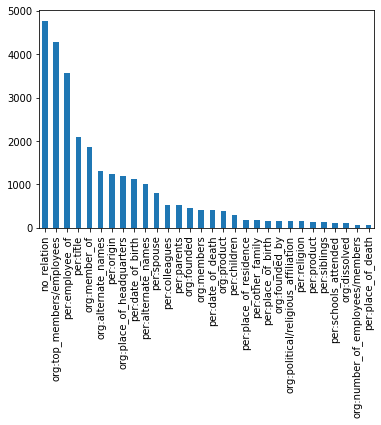

In [193]:
set_diff_df['label'].value_counts().plot(kind='bar')

In [194]:
set_diff_df.to_csv("./half_no_relation.csv")